In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [111]:
import numpy as np 
import pandas as pd 

import string

import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, inaugural
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
    recall_score, f1_score, log_loss, auc, classification_report, confusion_matrix, \
    precision_recall_curve, roc_curve, plot_confusion_matrix

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
train_df = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv')
test_df = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv')

In [59]:
print(train_df.shape, test_df.shape)

(900000, 11) (478033, 10)


In [60]:
train_df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


In [8]:
train_df.rating.value_counts()

4    313688
5    265007
3    188972
2     72627
0     30988
1     28718
Name: rating, dtype: int64

<AxesSubplot:xlabel='rating', ylabel='count'>

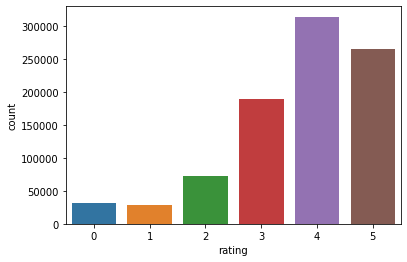

In [26]:
sns.countplot(x = train_df.rating)

<AxesSubplot:>

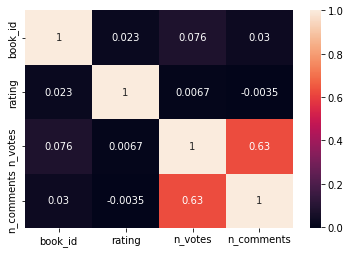

In [9]:
sns.heatmap(train_df.corr(), annot=True)

In [10]:
train_df[['review_text']].head(10).values

array([['This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. (view spoiler)[Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would happen if our SETI stations received a message - if we found someone was out there - and the person monitoring and answering the 

In [11]:
train_df.isna().sum()

user_id              0
book_id              0
review_id            0
rating               0
review_text          0
date_added           0
date_updated         0
read_at          91766
started_at      274297
n_votes              0
n_comments           0
dtype: int64

In [12]:
train_df.review_text.nunique()

890254

In [15]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        colormap =  'Pastel2',
        scale = 3,
        random_state = 123
    ).generate(str(data))

    fig = plt.figure(1, figsize = (13, 13))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

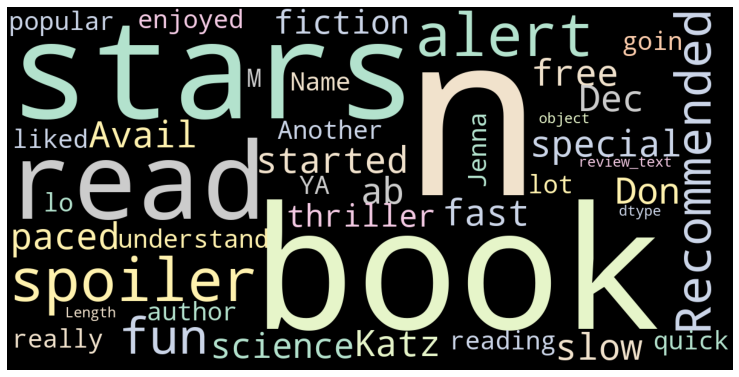

In [16]:
show_wordcloud(train_df["review_text"])

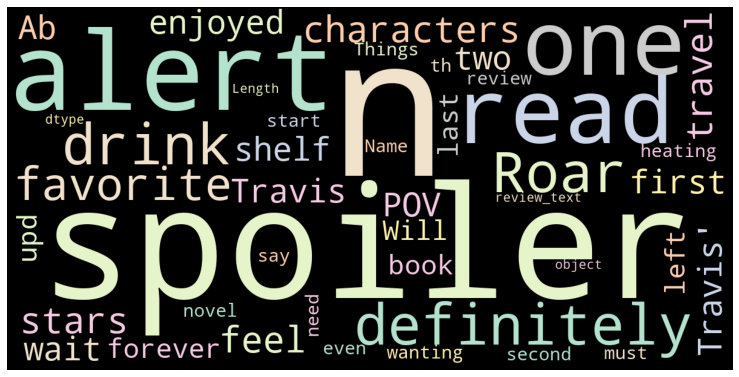

In [17]:
show_wordcloud(test_df["review_text"])

## Data Preproccesing

In [62]:
# Removing url
train_df['review_text'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)
test_df['review_text'].astype(str).replace( { r"http\S+" : '' }, inplace= True, regex = True)

In [63]:
stop_words = stopwords.words("english")
to_drop = string.punctuation + string.digits

lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocessing(data):
    words = data.translate(str.maketrans(to_drop, ' '*len(to_drop))).lower().split()

    return (' '.join([lemmatizer.lemmatize(word) for word in words if word not in stop_words])).strip()


train_df['review_text'] = train_df['review_text'].apply(preprocessing)

train_df['review_text'].sample(5)

302826                  wow actually feel character growing
884983    vampire academy anyone even begin started book...
465749    enjoyable historical fiction life curious crea...
545562    reread refresh reading next one love series wa...
878445    read girl scout camp year back long story foun...
Name: review_text, dtype: object

In [64]:
test_df['review_text'] = test_df['review_text'].apply(preprocessing)

In [65]:
#drop hashtags and mentions
train_df['review_text'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)
train_df['review_text'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

test_df['review_text'].replace( { r"#(\w+)" : '' }, inplace= True, regex = True)
test_df['review_text'].replace( { r"@(\w+)" : '' }, inplace= True, regex = True)

In [66]:
# droping extra columns
train_df.drop(columns=['date_updated', 'read_at', 'started_at'], axis=1, inplace=True)
test_df.drop(columns=['date_updated', 'read_at', 'started_at'], axis=1, inplace=True)

In [67]:
# books with negative n_votes or n_comments are not relevant
train_df = train_df[(train_df['n_votes'] >= 0) & (train_df['n_comments'] >= 0)]

In [68]:
train_df.drop_duplicates(subset=['review_text'], inplace=True)

### Modelling

In [93]:
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import classification_report, confusion_matrix

In [70]:
def get_metrics(y_test_bin, y_test, y_pred, y_prob, name, type_multi):
    """
    y_test_bin - бинаризованные тестовые метки класса
    y_test - метки класса без бинаризации
    y_prob - предсказанные вероятности классов
    name - название модели/подхода
    type_multi - тип многоклассовой классификации для ROC-AUC (ovo/ovr)
    """
    
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['ROC_AUC'] = [
        roc_auc_score(y_test_bin, y_prob, multi_class=type_multi)
    ]
    df_metrics['Precision_micro'] = [
        precision_score(y_test, y_pred, average='micro')
    ]
    df_metrics['Precision_macro'] = [
        precision_score(y_test, y_pred, average='macro')
    ]
    df_metrics['Recall_micro'] = [
        recall_score(y_test, y_pred, average='micro')
    ]
    df_metrics['Recall_macro'] = [
        recall_score(y_test, y_pred, average='macro')
    ]
    df_metrics['F1_micro'] = [f1_score(y_test, y_pred, average='micro')]
    df_metrics['F1_macro'] = [f1_score(y_test, y_pred, average='macro')]
    df_metrics['Logloss'] = [log_loss(y_test, y_prob)]

    return df_metrics

In [30]:
X = train_df['review_text']
y = train_df['rating'].values


In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33,  
                                                  stratify=y,shuffle=True,
                                                  random_state=123)

In [32]:
y_val_bin = label_binarize(y_val, classes=list(set(y_val)))

In [33]:
tfidf = TfidfVectorizer(use_idf=True)

X_train_vec = tfidf.fit_transform(X_train) 
X_val_vec = tfidf.transform(X_val)

In [37]:
def ovo_modelling():
    metrics = pd.DataFrame()
    for base_clf in [MultinomialNB(), LogisticRegression()]:
        
        ovo = OneVsOneClassifier(base_clf).fit(X_train_vec, y_train)
        
        y_pred = ovo.predict(X_val_vec)
        y_score = ovo.decision_function(X_val_vec)
        metrics = metrics.append(get_metrics(y_test_bin=y_val_bin,
                      y_test=y_val,
                      y_pred=y_pred,
                      y_prob=y_score,
                      name=f'ovo_{base_clf}_Baseline',
                      type_multi='ovo'))

    return metrics

In [39]:
ovo_modelling()

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,ovo_MultinomialNB()_Baseline,0.753172,0.439178,0.452043,0.439178,0.225529,0.439178,0.192614,2.319488
0,ovo_LogisticRegression()_Baseline,0.812524,0.531622,0.518917,0.531622,0.414473,0.531622,0.447090,1.845191


In [40]:
train_df.shape

(882211, 8)

In [86]:
train_df_sample = train_df.sample(20000)
X = train_df_sample['review_text']
y = train_df_sample['rating'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33,  
                                                  stratify=y,shuffle=True,
                                                  random_state=123)

y_val_bin = label_binarize(y_val, classes=list(set(y_val)))
tfidf = TfidfVectorizer(use_idf=True)

X_train_vec = tfidf.fit_transform(X_train) 
X_val_vec = tfidf.transform(X_val)

In [87]:
from tqdm import tqdm
def ovo_modelling():
    metrics = pd.DataFrame()
    for base_clf in tqdm([RandomForestClassifier(), XGBClassifier(), lgb.LGBMClassifier()]):
        
        ovo = OneVsOneClassifier(base_clf).fit(X_train_vec, y_train)
        
        y_pred = ovo.predict(X_val_vec)
        y_score = ovo.decision_function(X_val_vec)
        metrics = metrics.append(get_metrics(y_test_bin=y_val_bin,
                      y_test=y_val,
                      y_pred=y_pred,
                      y_prob=y_score,
                      name=f'ovo_{base_clf}_Baseline',
                      type_multi='ovo'))

    return metrics

In [88]:
ovo_modelling()

100%|██████████| 3/3 [04:20<00:00, 86.90s/it] 


,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,ovo_RandomForestClassifier()_Baseline,0.733447,0.441364,0.440466,0.441364,0.239118,0.441364,0.222823,2.286236
0,"ovo_XGBClassifier(base_score=None, booster=Non...",0.744024,0.460758,0.481248,0.460758,0.301055,0.460758,0.320669,2.147285
0,ovo_LGBMClassifier()_Baseline,0.755478,0.472273,0.456924,0.472273,0.311635,0.472273,0.330282,2.100683


## Tuning

In [92]:
X = train_df['review_text']
y = train_df['rating'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33,  
                                                  stratify=y,shuffle=True,
                                                  random_state=123)

y_val_bin = label_binarize(y_val, classes=list(set(y_val)))
tfidf = TfidfVectorizer(use_idf=True)

X_train_vec = tfidf.fit_transform(X_train) 
X_val_vec = tfidf.transform(X_val)

In [100]:
parameters_grid = [{
    'estimator__penalty': ['l2', 'elasticnet'],
    #'estimator__C': np.logspace(-3, 3, num=10),
    'estimator__solver': ['newton-cg', 'sag'],
    'estimator__max_iter': [1000],
    'estimator__class_weight': ['balanced']
}]

lr = LogisticRegression()
model = OneVsOneClassifier(lr)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

grid_cv = GridSearchCV(model, parameters_grid,
                       scoring='f1_macro', cv=cv, verbose=1)

In [101]:
%%time
grid_cv.fit(X_train_vec, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/multiclass.py", line 746, in fit
    for i in range(n_classes)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", l

CPU times: user 24min 1s, sys: 21min 1s, total: 45min 3s
Wall time: 20min 47s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=OneVsOneClassifier(estimator=LogisticRegression()),
             param_grid=[{'estimator__class_weight': ['balanced'],
                          'estimator__max_iter': [1000],
                          'estimator__penalty': ['l2', 'elasticnet'],
                          'estimator__solver': ['newton-cg', 'sag']}],
             scoring='f1_macro', verbose=1)

In [102]:
grid_cv.best_params_

{'estimator__class_weight': 'balanced',
 'estimator__max_iter': 1000,
 'estimator__penalty': 'l2',
 'estimator__solver': 'sag'}

In [103]:
grid_cv.best_score_

0.4256263593039215

In [104]:
best_params = {
    key.split('estimator__')[1]: value
    for key, value in list(grid_cv.best_params_.items())
}
best_params

{'class_weight': 'balanced',
 'max_iter': 1000,
 'penalty': 'l2',
 'solver': 'sag'}

In [108]:
lr = LogisticRegression(**best_params)
ovo = OneVsOneClassifier(lr)
ovo.fit(X_train_vec,y_train)
y_pred = ovo.predict(X_val_vec)
y_score = ovo.decision_function(X_val_vec)
get_metrics(y_test_bin=y_val_bin,
                      y_test=y_val,
                      y_pred=y_pred,
                      y_prob=y_score,
                      name='ovo_logistic_regresion_Tuning',
                      type_multi='ovo')

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,ovo_logistic_regresion_Tuning,0.811141,0.485859,0.409255,0.485859,0.492039,0.485859,0.428075,1.964427


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 1080x432 with 0 Axes>

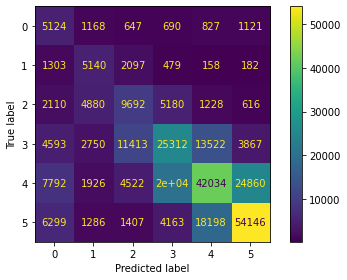

In [114]:
fig = plt.figure(figsize=(15, 6))

plot_confusion_matrix(ovo,
                      X_val_vec,
                      y_val)

plt.tight_layout()  
plt.show();

## Testing

In [115]:
X_test = test_df['review_text']
X_test = tfidf.transform(X_test)

In [121]:
submisions = pd.DataFrame()
submisions['review_id'] = test_df.review_id
submisions['rating'] = ovo.predict(X_test)
submisions.head()

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,0
3,8a46df0bb997269d6834f9437a4b0a77,3
4,d11d3091e22f1cf3cb865598de197599,3


In [122]:
submisions.to_csv("submisions.csv", index = False)